# Misc dataset

In [1]:
from model.graph_mcmc import Graph_MCMC

In [2]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 22})

In [3]:
graph = Graph_MCMC()
graph.read_from_ns("sp_primary_school/day_2") # escorts could be fun

In [4]:
graph.rename_property("label", "_label")
graph.rename_property("viz", "_viz")

True

In [5]:

graph.convert_props_to_flags()
graph.remove_property("Unknown")

True

In [6]:
graph.list_props()

name                   (graph)   (type: string, val: sp_primary_school (day_2))
description            (graph)   (type: string, val: Two temporal networks of
                                                     contacts among students
                                                     and teachers at a primary
                                                     school in Lyon, France, on
                                                     consecutive days of in
                                                     October 2009. Each network
                                                     accumulates all contacts
                                                     over the course of a
                                                     single day; contacts were
                                                     sampled at 20-second
                                                     intervals)
citation               (graph)   (type: string, val: ['Juliette Stehle et al.,
  

In [7]:
graph.print_info()
graph.partition(B_min=10, B_max=10)

Graph with N=238 nodes, E=5539 edges and D=13 vertex features for training
Performing inference...
Current bracket: (10, 10, 10) (10964.243293437694, 10964.243293437694, 10964.243293437694)
Current bracket: (10, 10, 10) (10964.243293437694, 10964.243293437694, 10964.243293437694)
Bisect at B = 10 with S = 10964.24329343769
Best result: B = 10, S = 10964.24329343769
Done


<VertexPropertyMap object with value type 'int32_t', for Graph 0x7f409c1bb280, at 0x7f402aba8550>

In [8]:
av_dl = graph.mcmc(num_iter=10000)

100%|██████████| 10000/10000 [00:21<00:00, 459.43it/s]


Drawing soft partition


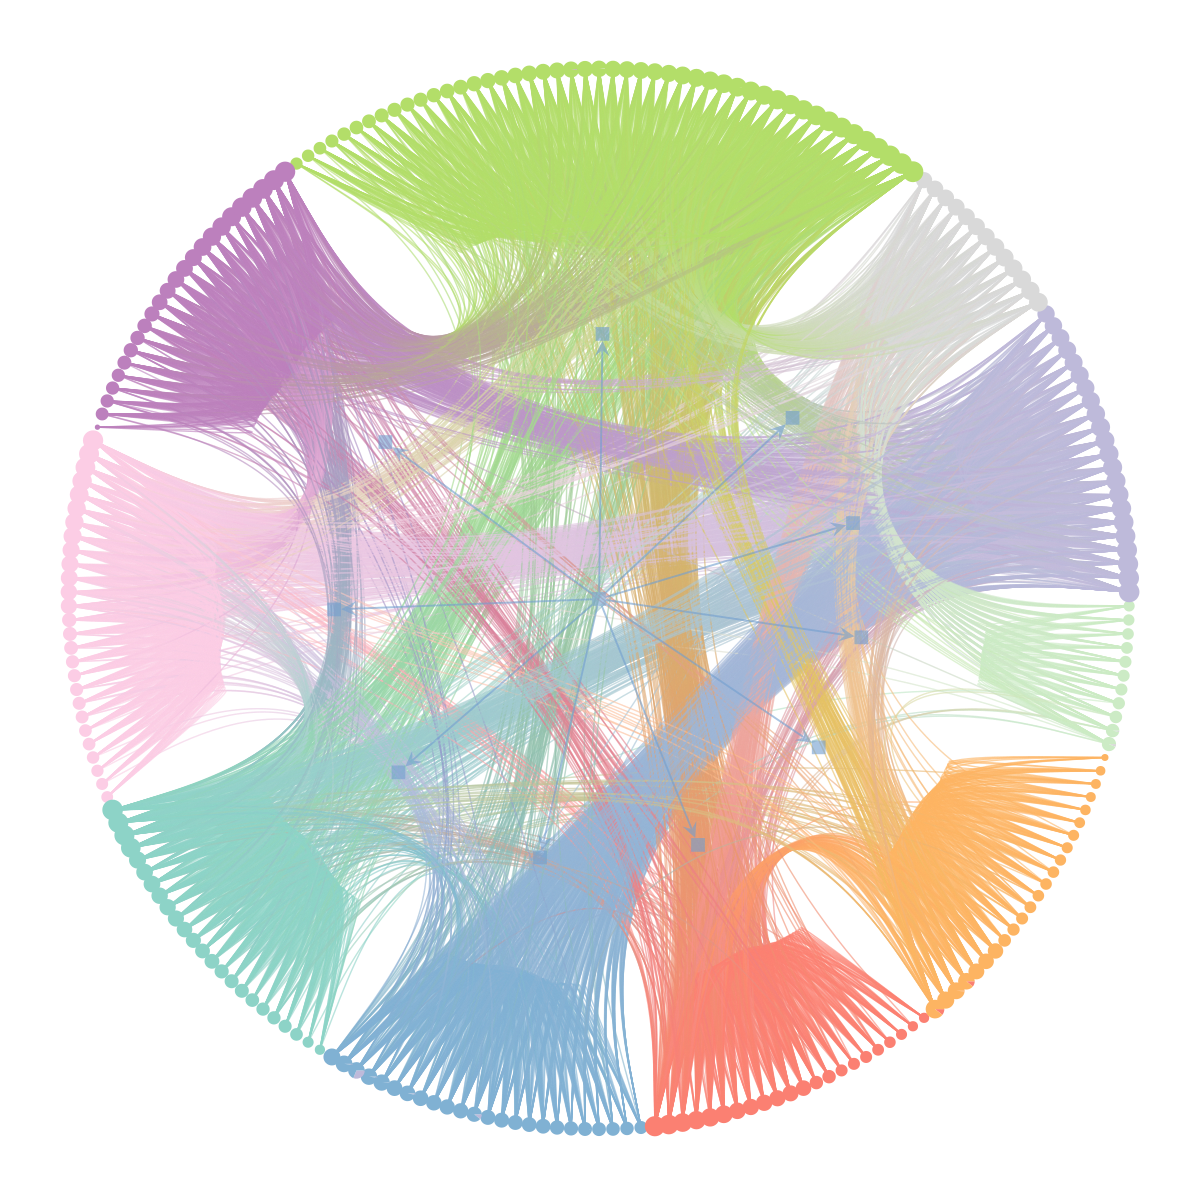

In [9]:
#graph.draw(gen_layout=False, size=10, output="school-graph.png")
graph.draw()

Drawing block adjacency matrix $e_{rs}$


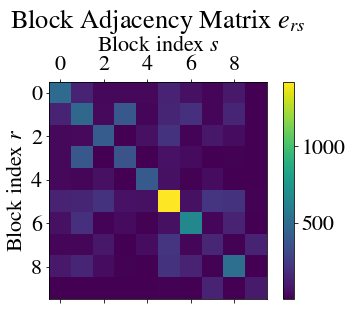

In [10]:
graph.plot_matrix()

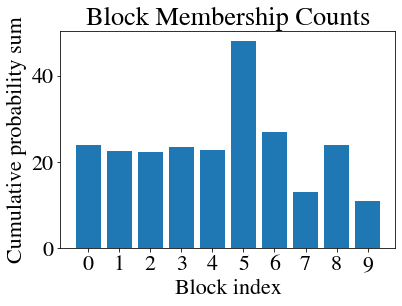

In [11]:
graph.plot_posterior_props()

## Train classifier

In [12]:
from inference.softmax import SoftmaxNeuralNet
import numpy as np

In [13]:
X = graph.generate_feature_matrix()
Y = graph.generate_posterior()

D = X.shape[1]
B = Y.shape[1]

N = X.shape[0]
assert N == Y.shape[0]



In [14]:
from utils.subsampling import random_index_arr

train_indices, test_indices = random_index_arr(N, fraction=0.8)
X_train, Y_train = X[train_indices, :], Y[train_indices, :]
X_test, Y_test = X[test_indices, :], Y[test_indices, :]

In [15]:
classifier = SoftmaxNeuralNet(layers_size=[D, B], sigma=1)
acceptance_ratio, final_accuracy = classifier.perform_mala(X_train, Y_train, step_scaling=0.2, num_iter=10000, verbose=True)

100%|██████████| 10000/10000 [00:12<00:00, 790.80it/s]Sample accept ratio: 80.66%
Train. set accuracy: 84.73684210526315%



In [32]:
T = 10000
n = 10
step_sizes = np.logspace(-2, 1, n) # base 10
acceptance_arr = np.zeros(n)
loss_arr = np.zeros(n)
std_arr = np.zeros(n)

for i in range(0, n):
    temp_classifier = SoftmaxNeuralNet(layers_size=[D, B], sigma=1)
    acc, _ = temp_classifier.perform_mala(X_train, Y_train, step_scaling=step_sizes[i], num_iter=T)
    acceptance_arr[i] = acc
    loss_arr[i], std_arr[i] = temp_classifier.mean_std_normalised_U()


100%|██████████| 10000/10000 [00:07<00:00, 1296.59it/s]


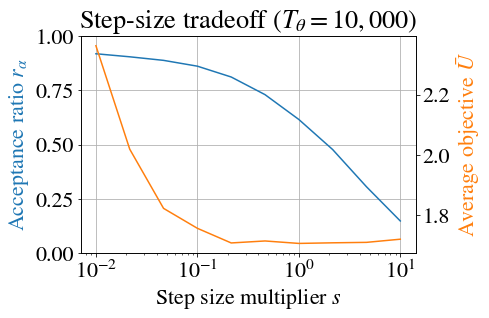

In [38]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_title(r"Step-size tradeoff ($T_\theta = 10,000$)")
ax.plot(step_sizes, acceptance_arr, color="C0")
ax.set_xscale('log')
ax.set_ylim((0,1))
ax.set_ylabel(r"Acceptance ratio $r_\alpha$", color="C0")
ax.set_xlabel(r"Step size multiplier $s$")
ax2 = ax.twinx()
ax2.plot(step_sizes, loss_arr, color="C1")
ax2.set_ylabel(r"Average objective $\bar{U}$", color="C1")
ax.grid()


## Interpret results

### Thinning

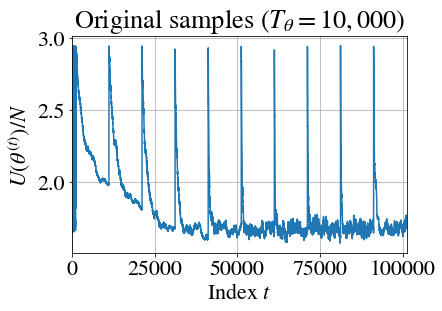

(1.8098377837322892, 0.2592218609093731)

In [31]:
classifier.plot_U(title=r"Original samples ($T_\theta=10,000$)")
classifier.mean_std_normalised_U()

In [19]:
classifier.thin_samples(burn_in=0.4, thin_factor=10)

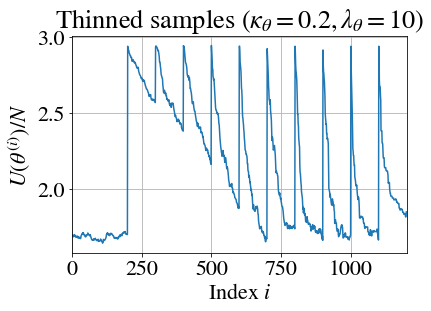

2.109102810218407


In [20]:
u_mean = classifier.plot_U(title=r"Thinned samples ($\kappa_\theta=0.2, \lambda_\theta=10$)", index_symbol="i")
print(u_mean)

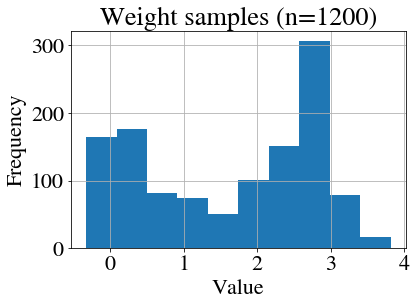

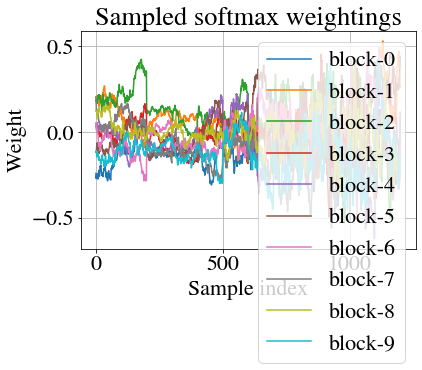

In [21]:
classifier.plot_sample_histogram()
classifier.plot_sample_history()

### Performance

In [22]:
training_loss = classifier.average_loss_per_point(X_train, Y_train, include_prior=False)
test_loss = classifier.average_loss_per_point(X_test, Y_test, include_prior=False)

print("Training loss: {}, Test loss: {}".format(training_loss, test_loss))


Training loss: 1.308392136513585, Test loss: 1.2946240239669828


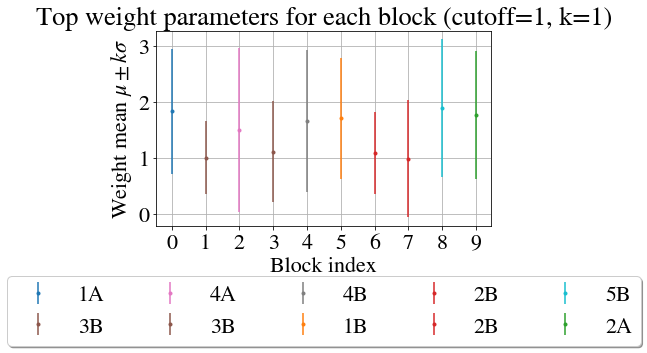

In [23]:
names = list(graph.get_feature_names())
classifier.plot_block_principal_dims(names, cutoff=1, legend=True)

Max cutoff: 0.04696148238958159
Discarded 4 features


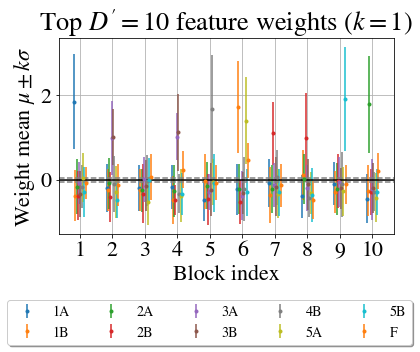

In [24]:
matplotlib.pyplot.rc('legend',fontsize=14)
names = list(graph.get_feature_names())
kept_features = classifier.plot_sampled_weights(names, std_dev_multiplier=1, D_reduced=10, legend=True, ncol=5)

In [25]:
reduced_X_train, reduced_X_test = X_train[:, kept_features], X_test[:, kept_features]

reduced_D = reduced_X_train.shape[1]
B = Y_train.shape[1]

# nwo train new classifier
reduced_classifier = SoftmaxNeuralNet(layers_size=[reduced_D, B], sigma=1)
reduced_classifier.perform_mala(reduced_X_train, Y_train, step_scaling=0.2, num_iter=10000, verbose=True)

100%|██████████| 10000/10000 [00:08<00:00, 1205.60it/s]Sample accept ratio: 83.16%
Train. set accuracy: 74.73684210526315%



(0.8316, 0.7473684210526316)

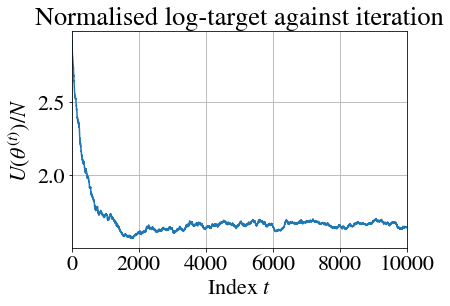

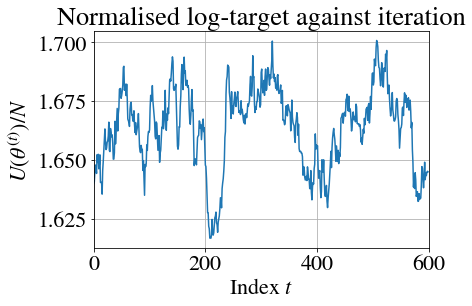

1.6639195431952225

In [26]:
reduced_classifier.plot_U()
reduced_classifier.thin_samples(burn_in=0.4, thin_factor=10)
reduced_classifier.plot_U()

In [27]:
reduced_training_loss = reduced_classifier.average_loss_per_point(reduced_X_train, Y_train, include_prior=False)
reduced_test_loss = reduced_classifier.average_loss_per_point(reduced_X_test, Y_test, include_prior=False)

print("REDUCED CLASSIFIER -- Training loss: {}, Test loss: {}".format(reduced_training_loss, reduced_test_loss))

REDUCED CLASSIFIER -- Training loss: 0.8760349202047175, Test loss: 0.8833980103339554


In [28]:
print("Average description length per entity: {}".format(av_dl))
print("Training loss: {}, Test loss: {}".format(training_loss, test_loss))
print("D': {}".format(len(kept_features)))
print("REDUCED CLASSIFIER -- Training loss: {}, Test loss: {}".format(reduced_training_loss, reduced_test_loss))

Average description length per entity: 1.8890033739607721
Training loss: 1.308392136513585, Test loss: 1.2946240239669828
D': 10
REDUCED CLASSIFIER -- Training loss: 0.8760349202047175, Test loss: 0.8833980103339554
